In [5]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sbn
import matplotlib.pyplot as plt
import bokeh.palettes

In [6]:
%matplotlib inline

In [8]:
with open("../Data/Mutation_data//Strain_to_genes.json") as infile:
    strain_to_genes = json.load(infile)
    strain_to_genes = {k: v for k, v in strain_to_genes.items() if not (k.startswith("12PD") or k.startswith("BUT"))}
    
with open("../Data/Mutation_data//All_strains_to_mutations.json") as infile:
    strain_to_mutations = json.load(infile)
    strain_to_mutations = {k: v for k, v in strain_to_mutations.items() if k in strain_to_genes}
    
mutation_to_strains = {}
mutation_to_populations = {}
for s, muts in strain_to_mutations.items():
    for mut in muts:
        mutation_to_strains.setdefault(mut, []).append(s)
        mutation_to_populations.setdefault(mut, set()).add(s.split("-")[0])
    
with open("../Data/Mutation_data//Mutations_to_gene_names.json") as infile:
    mutation_to_genes = json.load(infile)
    
gene_to_mutations = {}
for mut, genes in mutation_to_genes.items():
    for g in genes:
        gene_to_mutations.setdefault(g, []).append(mut)

In [9]:
comp_dup_counts = {}
for mut in mutation_to_genes:
    if mut.startswith("DUP"):
        length = mut.split("_")[0].split("-")[2]
        length = int(length.replace(",", ""))
        s = mutation_to_strains.get(mut)
        if s is not None and length > 500:
            for strain in s:
                comp = strain#[:5]
                comp_dup_counts[comp] = comp_dup_counts.get(comp, 0) + 1
                print(mut, mutation_to_strains.get(mut))

DUP-2753199-67,717_2.1 ['23BD5-1']
DUP-2315333-2,124_1.9 ['23BD8-2']
DUP-2944187-2,394_1.7 ['COUM2-3']
DUP-3630689-5,301_2.0 ['IBUA5-2']
DUP-31546-12,593_1.9 ['COUM6-9']
DUP-2277221-1,144_1.6 ['COUM2-3']
DUP-2743383-2,187_1.6 ['COUM2-3']
DUP-2302135-25,648_1.9 ['23BD4-4']
DUP-2702536-1,664_1.7 ['COUM2-3']
DUP-2793906-8,641_1.7 ['COUM2-3']
DUP-2789482-1,918_1.7 ['COUM2-3']
DUP-2474406-27,777_2.1 ['23BD5-1']
DUP-3583450-709_3.4 ['OCTA8-5']
DUP-2529740-3,743_1.8 ['23BD8-2']
DUP-2496449-755_1.9 ['23BD8-2']
DUP-2432702-1,475_1.8 ['23BD8-2']
DUP-2822025-23,735_2.0 ['23BD5-1']
DUP-2283904-3,650_1.6 ['COUM2-3']
DUP-3671106-32,513_1.9 ['COUM2-3']
DUP-3793824-3,089_2.6 ['HEXA2-3']
DUP-3019113-6,039_1.7 ['COUM2-3']
DUP-2919104-10,552_1.7 ['COUM2-3']
DUP-2615290-3,271_1.6 ['COUM2-3']
DUP-3002553-7,438_1.6 ['COUM2-3']
DUP-2328702-31,985_1.9 ['23BD4-4']
DUP-3688423-4,345_2.0 ['IBUA4-1']
DUP-2732699-6,691_1.6 ['COUM2-3']
DUP-2734643-16,274_2.1 ['23BD4-4']
DUP-2449738-1,755_1.6 ['COUM2-3']
DUP-2482796

In [10]:
gene_df = pd.DataFrame({s: {g: 1 for g in genes} for s, genes in strain_to_genes.items()}).fillna(0)
pop_gene_df = gene_df.transpose()
pop_gene_df["population"] = pop_gene_df.index.map(lambda x: x.split("-")[0])
pop_gene_df = pop_gene_df.groupby("population").sum().astype("bool").transpose()

compound_order = ["23BD", "PUTR", "HMDA", "HEXA", "OCTA", "GLUT", "ADIP", "COUM", "IBUA"]

sorted_strains = sorted(pop_gene_df.columns, key=lambda x: (compound_order.index(x[:4]), x), reverse=True)
pop_gene_df = pop_gene_df[sorted_strains]

In [13]:
variant_dir = "../Data/Mutation_data/Variant_calls/"

snp_effects = {}

for f in (f for f in os.listdir(variant_dir) if not f.startswith(".") and not f.startswith("mapping")):
    var_df = pd.read_csv(variant_dir + f)
    for i, row in var_df.iterrows():
        if not row["Mutation Type"] == "SNP":
            continue
        snp_id = "SNP-" + str(int(row["Position"].replace(",", ""))) + "-" + row["Sequence Change"][-1]
        gene = row["Gene"]
        effect = row["Protein change"].replace("\xa0", " ").split(" ")
        if effect[0] not in ("intergenic", "pseudogene"):
            snp_effects[snp_id] = (gene, effect[0], effect[1].strip("()"))

            
rpo_effects = {k: v for k, v in snp_effects.items() if v[0].startswith("rpo")}

In [14]:
mut_df = pd.DataFrame({s: {m: 1 for m in muts} for s, muts in strain_to_mutations.items()}).fillna(0)
pop_mut_df = mut_df.transpose()
pop_mut_df["population"] = pop_mut_df.index.map(lambda x: x.split("-")[0])
pop_mut_df = pop_mut_df.groupby("population").sum().astype("bool").transpose()

compound_order = ["23BD", "PUTR", "HMDA", "HEXA", "OCTA", "GLUT", "ADIP", "COUM", "IBUA"]

rpo_df = pop_mut_df.reindex(list(rpo_effects))
rpo_df = rpo_df.dropna()
sorted_strains = sorted(rpo_df.columns, key=lambda x: (compound_order.index(x[:4]), x), reverse=True)
rpo_df = rpo_df[sorted_strains]

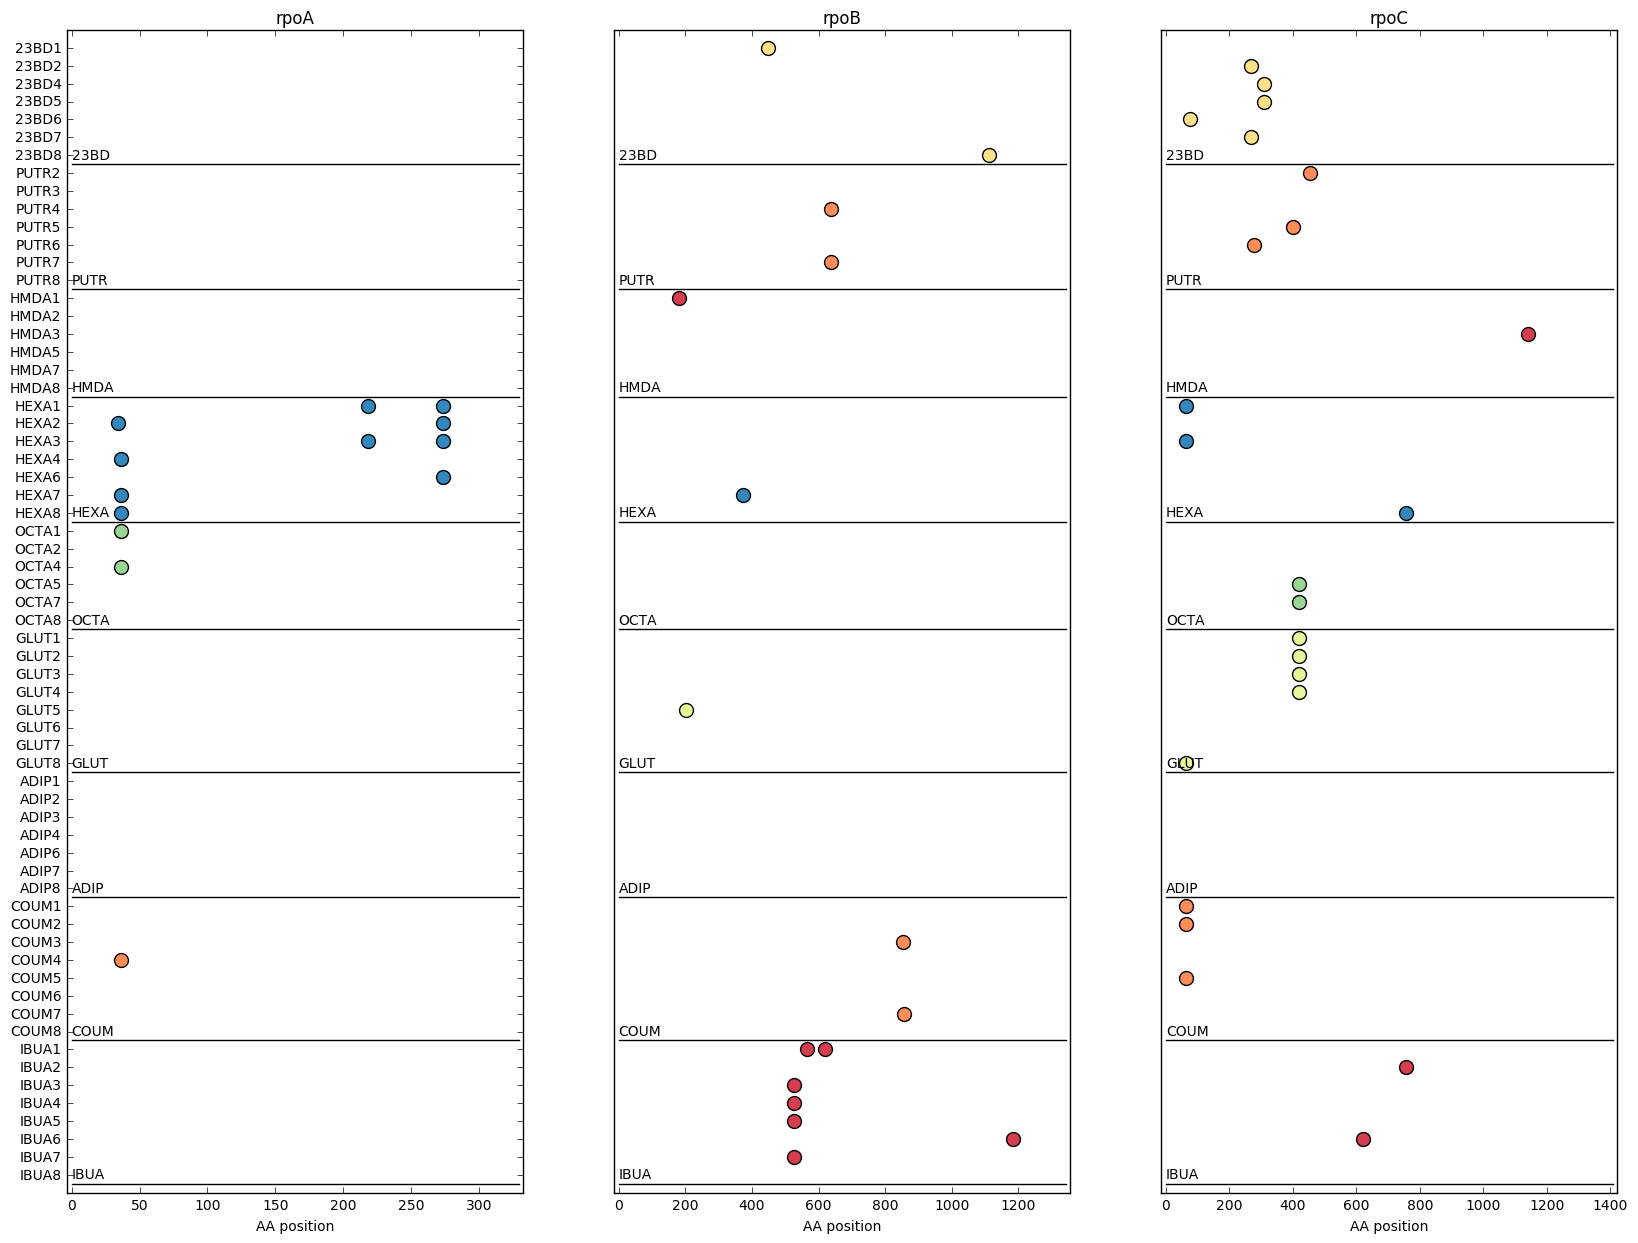

In [15]:
fig = plt.figure(figsize=[20, 15])

ls = [329, 1342, 1407, 613]

for i, rpo in enumerate(("rpoA", "rpoB", "rpoC")):
    colors = list(bokeh.palettes.Spectral6) * 3
    pops = []
    
    ax = fig.add_subplot(1, 3, i+1)
    plt.title(rpo[0].lower()+rpo[1:])
    for pop in rpo_df:
        ser = rpo_df[pop]
        ser = ser[ser]
        positions = [int(rpo_effects[m][1][1:-1]) for m in ser.index if rpo_effects[m][0] == rpo]
        if not pops or pop[:4] != pops[-1][:4]:
                #print(len(pops))
                color = colors.pop()
                plt.text(0, float(len(pops))+0.8, s=pop[:4])
                plt.plot([0, ls[i]], [len(pops)+0.5]*2, "-k")
        if len(positions) > 0:
            #print(pop)
            pops.append(pop)
            plt.plot(positions, [len(pops)]*len(positions), "o", color=color, markersize=10, markeredgewidth=1, markeredgecolor="black")
        else:
            pops.append(pop)
    plt.ylim([0, 65])
    plt.xlim([-0.01*ls[i], ls[i]*1.01])
    plt.xlabel("AA position")
    if i == 0:
        ax.set_yticks(range(1, len(pops)+1))
        ax.set_yticklabels(pops)
    else:
        ax.set_yticks([])


plt.savefig("../Plots/RNAP_mutation_sites.png", transparent=False)